# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [28]:
#импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier # модель древа решений
from sklearn.ensemble import RandomForestClassifier # модели случайного леса
from sklearn.linear_model import LogisticRegression # модель логистической регрессии

from sklearn.model_selection import train_test_split # разбивка выборки на обучающую и тестовую
from sklearn.metrics import accuracy_score # accuracy 
from sklearn.metrics import precision_score # точность 
from sklearn.metrics import recall_score # полнота

In [29]:
#открываем файт
df = pd.read_csv('/datasets/users_behavior.csv')

In [30]:
#посмотрим
display(df.sample(10))

,calls,minutes,messages,mb_used,is_ultra
464,87.0,586.98,56.0,13389.11,0
1115,64.0,495.20,21.0,20048.69,0
1309,70.0,533.41,54.0,20011.87,0
683,97.0,772.35,66.0,10523.42,1
974,66.0,465.75,6.0,16832.32,0
1316,88.0,564.56,0.0,13344.02,0
2664,73.0,526.53,2.0,33886.45,0
476,52.0,378.36,25.0,22201.20,1
2950,97.0,705.23,30.0,14103.81,0
3154,69.0,488.40,36.0,14165.05,0


In [31]:
# проверим нет ли пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [32]:
# проверим нет ли отрицательных значений
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [33]:
print(df[df['is_ultra'] == 1]['calls'].shape[0], 'пользователей тарифа Ультра в датафрейме')
print(df[df['is_ultra'] == 0]['calls'].shape[0], 'пользователей тарифа Смарт в датафрейме')

985 пользователей тарифа Ультра в датафрейме
2229 пользователей тарифа Смарт в датафрейме


Пользователей Ультра маловато. Это будет снижать качество модели.

In [34]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas_profiling
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

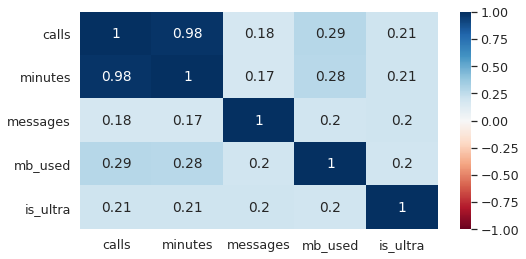

In [36]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df.corr(),        
    cmap='RdBu', 
    annot=True, 
    vmin=-1, vmax=1)

In [37]:
# корреляция звонки-минуты
print('корреляция м-ду количеством звонков и количеством потраченных минут:', round(df['calls'].corr(df['minutes']), 2))

корреляция м-ду количеством звонков и количеством потраченных минут: 0.98


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='calls', ylabel='minutes'>

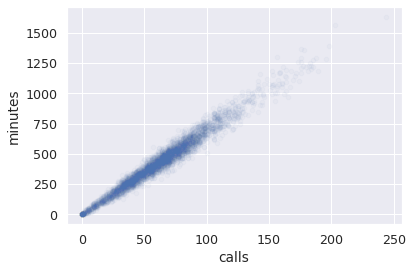

In [38]:
# скатерплот звонки-минуты 
df.plot(kind='scatter', x='calls', y='minutes', alpha=0.03)

<AxesSubplot:xlabel='calls', ylabel='minutes'>

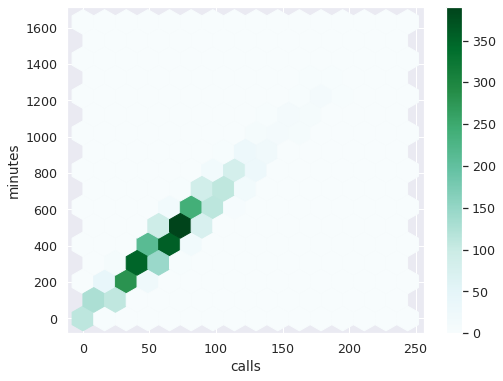

In [39]:
df.plot(kind='hexbin', x='calls', y='minutes', gridsize=15, figsize=(8, 6), sharex=False, grid=True)

М-ду количеством звонков и количеством потраченых минут высокая положительная корреляция. Значит в регрессионной модели при использовании обоих эти переменных в качестве регрессоров будет мультиколлинеарность. Можно использовать только одну из переменных, а другую удалить. Или пытаться прибегнуть к регуляризации (L1, L2-норма). Например, в логистической регрессии.   

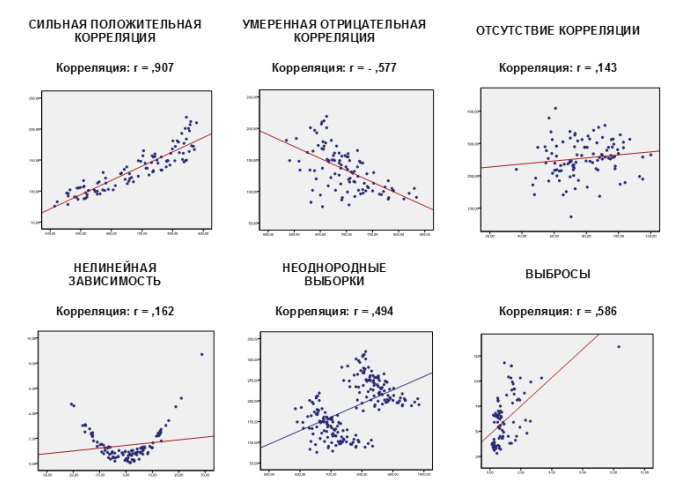

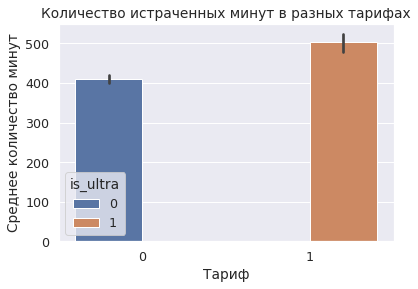

In [40]:
# бары is_ultra
ax = sns.barplot( 
    x='is_ultra',
    y='minutes', 
    data=df, 
    hue='is_ultra',
    estimator=np.median)

ax.set_title('Количество истраченных минут в разных тарифах')
ax.set(xlabel='Тариф', ylabel='Среднее количество минут');

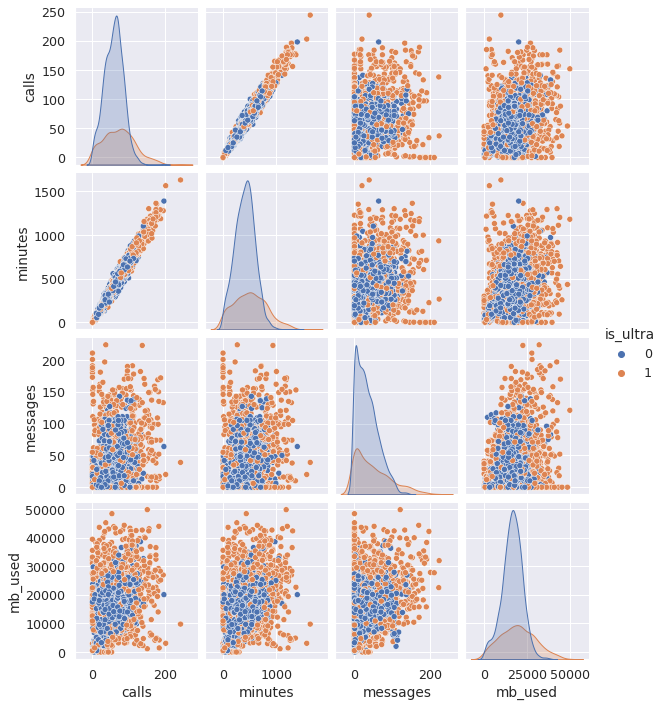

In [41]:
sns.pairplot(
    data=df, 
    aspect=.85,
    hue='is_ultra')

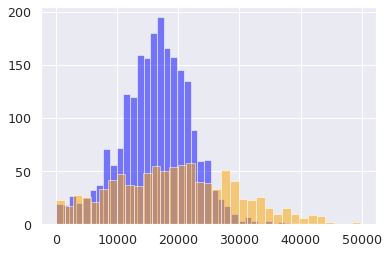

In [42]:
df[df['is_ultra'] == 0]['mb_used'].hist(bins=35, alpha=0.5, color='blue')
df[df['is_ultra'] == 1]['mb_used'].hist(bins=35, alpha=0.5, color='orange');

In [43]:
# таблица сопряженности по тарифам 
df.pivot_table(index='is_ultra', values=['calls', 'minutes', 'messages', 'mb_used'], aggfunc=['mean', 'median'])

mean                                      median            \
              calls       mb_used   messages     minutes  calls   mb_used   
is_ultra                                                                    
0         58.463437  16208.466949  33.384029  405.942952   60.0  16506.93   
1         73.392893  19468.823228  49.363452  511.224569   74.0  19308.01   

                           
         messages minutes  
is_ultra                   
0            28.0  410.56  
1            38.0  502.55

В среднем (и по медиане) пользователи Ультры делают больше звонков, тратят больше минут, гигабайтов и сообщений, чем пользователи Смарта.

In [44]:
# разделим данные на признаки и целевой признак 

features = df.drop(['is_ultra', 'calls'], axis=1) # из признаков уберем целевой
target = df['is_ultra'] # в цель поставим столбец с целевым признаком

**Вывод** В датафрейме пользователей Ультра в два раза меньше пользователей Смарт. (Это будет снижать качество модели). В среднем (и по медиане) пользователи Ультры делают больше звонков, тратят больше минут, гигабайтов и сообщений, чем пользователи Смарта.
<br><br>
М-ду количеством звонков и количеством потраченых минут высокая положительная корреляция. Это приводит к мультиколлинеарности регрессионной модели. Чтобы избежать ее, оставили только переменную с истраченным иминутами, а переменную с количеством звонков удалили из признаков для обучения валидации и тестирования модели. 

## Разбейте данные на выборки

Исходный df необходимо разбить на три части: обучающую, валидационную и тестовую выборку в пропорции 3:1:1 (60%, 20% и 20%, соответственно)

In [18]:
# разбили исходный df на обучающую и тестовую+валидационную (60% и 40%) 
# features_train, features_split, target_train, target_split = train_test_split(features, target, test_size=0.4, random_state=12345)

In [19]:
# разбили валидационную и тестовую (т.е. оставшиеся 40% на две половины)
# features_valid, features_test, target_valid, target_test = train_test_split(features_split, target_split, test_size=0.5, random_state=12345)

In [45]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

In [46]:
features_train['mb_used'].shape[0]

2410

In [21]:
# features_valid['mb_used'].shape[0]

643

In [47]:
features_test['mb_used'].shape[0]

804

Исходный df разделен на три части: обучающую(60%), валидационную(20%) и тестовую(20%) выборку. 

## Исследуйте модели

### Модель решающего дерева

In [23]:
best_model = None # пустая переменная для лучшей модели 
best_result = 0 # сюда будут класться самые высокие accuracy
for depth in range(1, 6): # глубина древа от 1 до 6
    model = DecisionTreeClassifier(criterion='entropy', random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print("Accuracy лучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

Accuracy лучшей модели на валидационной выборке: 0.7853810264385692 Глубина дерева: 3


### Модель случайного леса

In [24]:
best_model = None
best_result = 0.5
best_est = 0
best_depth = 0

#модель будет с количеством деревьев: от 10 до 50 с шагом 10
for est in range(10, 51, 10):
    # деревья будут с максимальной глубиной от 1 до 10
    for depth in range (1, 6):
        # инициализируйте модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) # обучите модель на обучающей выборке
        predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
        # Для каждой модели посчитаk RMSE на валидационной выборке
        result = accuracy_score(target_valid, predictions_valid)# посчитайте значение метрики rmse на валидационной выборке
        # Лучшая модель с максимальной accuracy
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy лучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Accuracy лучшей модели на валидационной выборке: 0.7869362363919129 Количество деревьев: 40 Максимальная глубина: 5


In [48]:
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,10, 1),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [50]:
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [51]:
grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 30}

### Логистическая регрессия

In [25]:
model = LogisticRegression(random_state=12345, 
                           solver='lbfgs', 
                           max_iter=1000)

model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = model.score(features_valid, target_valid)
print("Accuracy модели на валидационной выборке:", result)

Accuracy модели на валидационной выборке: 0.7076205287713841


| Модель              | Accuracy           | 
| :-------------------- | :-------------------- |
| Модель решающего дерева (Глубина дерева: 3)  | 0.785 |
| :-------------------- | :-------------------- |
| Модель случайного леса (Количество деревьев: 40 Максимальная глубина: 5)  | 0.787 |
| :-------------------- | :-------------------- |
| Логистическая регрессия   | 0.708 |

**Вывод: Лучшая модель, с наиболее высокой Accuracy на валидационной выборке (0.787) - модель cлучайного леса с количеством деревьев 40 и максимальной глубиной дерева 5.**

## Проверьте модель на тестовой выборке

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=5) 
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
result = accuracy_score(target_test, test_predictions)
accuracy = accuracy_score(target_train, model.predict(features_train))
print("Accuracy лучшей модели на тестовой выборке:", result)
print("Accuracy лучшей модели на обучающей выборке:", accuracy)

Accuracy лучшей модели на тестовой выборке: 0.7807153965785381
Accuracy лучшей модели на обучающей выборке: 0.8205394190871369


**Вывод:** Тестирование показало, что модель немного переобучена. Можно попытаться исправить это, сократив максимальную глубину дерева, но из-за этого Accuracy модели также будет сокращаться. 

In [52]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=8, min_samples_leaf=3, min_samples_split=4)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
result = accuracy_score(target_test, test_predictions)
accuracy = accuracy_score(target_train, model.predict(features_train))
print("Accuracy лучшей модели на тестовой выборке:", result)
print("Accuracy лучшей модели на обучающей выборке:", accuracy)

Accuracy лучшей модели на тестовой выборке: 0.8208955223880597
Accuracy лучшей модели на обучающей выборке: 0.8497925311203319


## (бонус) Проверьте модели на адекватность

Для проверки лучшей модели на адекватность сравним ее с моделью-классификатором, которая игнорирует параметры модели и в качестве предсказаний выдает тариф, который встречается чаще (Смарт).  

In [27]:
# зададим такую модель и посчитаем ее Accuracy
import numpy as np 
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
dummy_result = dummy_clf.score(features_train, target_train)
print("Accuracy модели игнорирующей параметры:", dummy_result)
if result > dummy_result:
    print("Лучашя модель адекватна")
else:
    print("Лучашя модель не адекватна")

Accuracy модели игнорирующей параметры: 0.6924273858921162
Лучашя модель адекватна


**Вывод:** на основе данных о поведении пользователей уже перешедших на тариф "Смарт" или "Ультра" была разработана модель для рекомендации этих тарифов. Это модель cлучайного леса с количеством деревьев 40 и максимальной глубиной дерева 5. Accuracy такой модели на тестовой выборке: 0.78. Модель несколько переобучена, но адекватна. Качество модели заметно снижено из-за того, что исходном датафрейме пользователей тарифа "Ультра" в два раза меньше, чем пользователей тарифа "Смарт".  

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
